# Nickolas4 - Portfolio Optimization

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader as dr
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco

In [2]:
#Generate portfolio
symbols = ['AAPL', 'MSFT', 'TLT', 'USO', 'GLD', 
           'SPY', 'CAT', 'KO', 'WMT', 'EMB']
asset_count = len(symbols)

In [3]:
#Empty DF to store web data
nickolas4 = pd.DataFrame()

In [4]:
risk_free = dr('^IRX', data_source='yahoo', 
                       start='2010-01-01')['Adj Close']/100
risk_free.tail()

Date
2017-04-24    0.00770
2017-04-25    0.00808
2017-04-26    0.00803
2017-04-27    0.00785
2017-04-28    0.00780
Name: Adj Close, dtype: float64

In [5]:
#Add 10 historic asset returns from Yahoo
for i in symbols:
    nickolas4[i] = dr(i, data_source='yahoo', 
    start='2010-01-01')['Adj Close'].round(2)
nickolas4.columns = symbols

nickolas4.tail()

,AAPL,MSFT,TLT,USO,GLD,SPY,CAT,KO,WMT,EMB
Date,,,,,,,,,,
2017-04-24,143.64,67.53,122.93,10.25,121.48,237.17,96.81,43.28,74.78,114.89
2017-04-25,144.53,67.92,121.45,10.36,120.25,238.55,104.42,43.11,75.05,114.60
2017-04-26,143.68,67.83,122.12,10.26,120.84,238.40,104.66,43.24,75.43,114.58
2017-04-27,143.79,68.27,122.08,10.24,120.39,238.60,102.68,43.01,75.44,114.84
2017-04-28,143.65,68.46,122.35,10.24,120.77,238.08,102.26,43.15,75.18,115.20


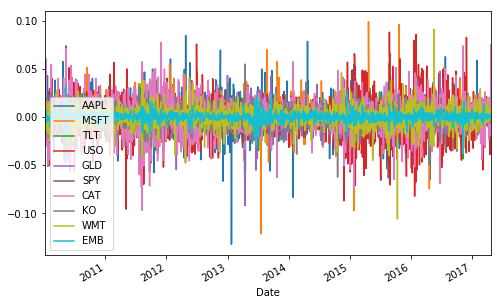

In [6]:
#DF of Logarithim Returns
n4_log = np.log(nickolas4/nickolas4.shift(1))
n4_log.plot(figsize=(8,5))

# 3.) Portfolio Optimization

#### Method 1 - Maximize Sharpe Ratio 

* Minimize negative values

In [7]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(n4_log.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(n4_log.cov() * 252, weights)))
    return np.array([pret, pvol, pret/pvol])

In [8]:
def maximize_sharpe(weights):
    return -statistics(weights)[2]

* Constraint is that all parameters add up to 1, and can be formulated using the conventions of the minimize function

In [10]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})

* Bound parameter values to be within 0 and 1. 


* These values are provided to the minimization function as a tuple of tuples in this case:

In [12]:
bnds = tuple((0, 1) for x in range(asset_count))

*  A starting parameter list (weight values) is needed to call the optimization function


* Equal Distribution of Weights of 10% (initial guesses for the weights). 

In [13]:
asset_count * [1. / asset_count,]

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

* Store optimization results in an object

In [16]:
opt_sharpe = sco.minimize(maximize_sharpe, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)

* Call the Function

In [17]:
opt_sharpe

     fun: -1.4579722430961826
     jac: array([  5.61401248e-04,   1.85932219e-03,  -1.32635236e-04,
         4.06373276e+00,   5.41859478e-01,   1.18702650e-04,
         6.16965845e-01,  -1.00772083e-03,  -5.54084778e-04,
        -7.91996717e-05])
 message: 'Optimization terminated successfully.'
    nfev: 151
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([  1.07619565e-01,   4.86043585e-03,   3.52933550e-01,
         3.61595179e-15,   2.98193951e-16,   2.56180325e-01,
         4.94041888e-16,   3.09715946e-02,   4.66099193e-03,
         2.42773539e-01])

* Retrieve the optimal portfolio composition by accessing the results object by providing the key of interest (x, in our case). 


* Optimal Portfolio has only 5 assets out of 10 total

In [19]:
pf_optimize_sharpe['x'].round(3)

array([ 0.108,  0.005,  0.353,  0.   ,  0.   ,  0.256,  0.   ,  0.031,
        0.005,  0.243])

In [20]:
#Portfolio weights sum to 1
np.sum(pf_optimize_sharpe['x'].round(3))

1.0009999999999999

#### Using the portfolio weights from the optimization, the following statistics emerge:

In [21]:
statistics(pf_optimize_sharpe['x']).round(3)

array([ 0.1  ,  0.068,  1.458])

#### Optimal Portfolio Weights

In [22]:
risk_free = risk_free.mean()
expd_return = statistics(pf_optimize_sharpe['x']).round(3)[0] - risk_free
expd_risk = statistics(pf_optimize_sharpe['x']).round(3)[1]
sharpe = statistics(pf_optimize_sharpe['x']).round(3)[2]

In [23]:
def portfolio_results():
    print "Portfolio Results (%)"
    print 30 * "-"
    print "Expected Return = %4.3f" % expd_return
    print "Risk free rate = %4.3f" %risk_free
    print "Standard Deviation = %4.3f" % expd_risk
    print "Sharpe Ratio = %4.3f" % sharpe
portfolio_results()

Portfolio Results (%)
------------------------------
Expected Return = 0.099
Risk free rate = 0.001
Standard Deviation = 0.068
Sharpe Ratio = 1.458


#### Method 2 -  Minimize Portfolo Variance

In [25]:
def minimize_variance(weights):
    return statistics(weights)[1] ** 2

In [27]:
#Absolute Minimum Variance Portfolio (on the efficient frontier curve)
opt_variance = sco.minimize(minimize_variance, asset_count * [1. / asset_count,], method='SLSQP',
                                   bounds = bnds, constraints=cons)

* Minimum variance portfolio only contains 5 assets ot of the possible 10.

In [29]:
opt_variance['x'].round(3)

array([ 0.   ,  0.   ,  0.248,  0.   ,  0.044,  0.14 ,  0.   ,  0.055,
        0.057,  0.456])

In [31]:
ER = statistics(opt_variance['x']).round(3)[0] - risk_free
STDEV = statistics(opt_variance['x']).round(3)[1]
SHARPE = statistics(opt_variance['x']).round(3)[2]

In [32]:
def portfolio_results():
    print "Portfolio Results (%)"
    print 30 * "-"
    print "Expected Return = %4.3f" % ER
    print "Standard Deviation = %4.3f" % STDEV
    print "Sharpe Ratio = %4.3f" % SHARPE
portfolio_results()

Portfolio Results (%)
------------------------------
Expected Return = 0.072
Standard Deviation = 0.059
Sharpe Ratio = 1.242
